In [1]:
import os, sys
import json
import h5py
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shutil import copyfile
from functools import reduce
from analysis.adapters.openephys import load_events
from analysis.adapters.vr import load_positions
from analysis.plots.utils import get_colors
from analysis.models.vr import RatCAVESession
from analysis.processing.epochs import get_epochs
from analysis.adapters.hdf5 import H5NAMES
from analysis.adapters.kwik import load_clu_res_single
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
COLORS = get_colors()

source = '/storage2/andrey/data/processed'
animals = ['003282']

In [4]:
def get_sessions(source, animal):
    def is_dir(name):
        return os.path.isdir(os.path.join(source, animal, name))

    def has_h5(name):
        return os.path.exists(os.path.join(source, animal, name, '%s.h5' % H5NAMES.filebase))
    
    return [x for x in os.listdir(os.path.join(source, animal)) if is_dir(x) and has_h5(x)]

In [5]:
stats = []
for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        with h5py.File(h5path, 'r') as f:
            traj = np.array(f['animal_trajectory'])
            r_idxs = np.array(f['running_idxs'])
            
        run_periods = []
        crit = np.where(np.diff(r_idxs) > 1)[0]
        
        run_periods.append( (int(traj[r_idxs[0]][0]), int(traj[r_idxs[crit[0]]][0])) )
        for i, point in enumerate(crit[1:]):
            p_start = int(traj[crit[i] + 1][0])
            p_end = int(traj[crit[i + 1] + 1][0])
            run_periods.append( (p_start, p_end) )
            
        run_periods = np.array(run_periods)
        
        running_duration = (run_periods[:, 1] - run_periods[:, 0]).sum()
        session_duration = traj[-1][0] - traj[0][0]
    
        stats.append([animal, session, running_duration/session_duration])

FileNotFoundError: [Errno 2] No such file or directory: '/storage2/andrey/data/processed/003282'

In [12]:
ds = pd.DataFrame(stats, columns=('animal', 'session', 'run'))

In [9]:
#ds

<Container object of 56 artists>

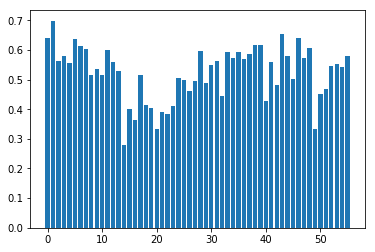

In [16]:
plt.bar(range(len(ds)), ds['run'])

### Look at velocity

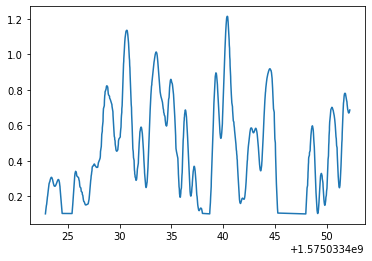

In [140]:
fpath = '/home/andrey/storage2/andrey/data/processed/003282/2019-11-29_14-16-57/all.h5'

with h5py.File(fpath, 'r') as f:
    traj = np.array(f['animal_trajectory'])
    r_idxs = np.array(f['running_idxs'])
    velocity = np.array(f['velocity'])
    
plt.plot(velocity[r_idxs][:2000, 0], velocity[r_idxs][:2000, 1])

### Update running periods based on velocity

In [44]:
source = '/home/andrey/storage2/andrey/data/processed'
animals = ['002784', '003281', '003282', '003908', '003909', '005363', '005364']

threshold = 0.1  # m/s

for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        with h5py.File(h5path, 'r+') as f:
            running_idxs = np.where(f['velocity'][:, 1] > threshold)[0]
            del f['running_idxs']
            f['running_idxs'] = running_idxs
            f['running_idxs'].attrs['threshold'] = threshold
            
    print('Animal %s done' % animal)

Animal 002784 done
Animal 003281 done
Animal 003282 done
Animal 003908 done
Animal 003909 done
Animal 005363 done
Animal 005364 done


### Theta mod cleaning

In [107]:
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']

for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        with h5py.File(h5path, 'r+') as f:
            for i, unit_group in enumerate(f['units']):
                if 'theta_mod' in f['units'][unit_group]:
                    del f['units'][unit_group]['theta_mod']
                    
    print('Animal %s done' % animal)

Animal 00908 done
Animal 00910 done
Animal 002784 done
Animal 003281 done
Animal 003282 done
Animal 003908 done
Animal 003909 done
Animal 005363 done
Animal 005364 done


### Spiketrains cleaning (first spike)

In [149]:
session = '/home/andrey/storage2/andrey/data/processed/00910/2019-07-25_20-54-31'

animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']
animals = ['005364']

for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        with h5py.File(h5path, 'r+') as f:
            units = np.array([(int(x.split('_')[0]), int(x.split('_')[1])) for x in f['units']])
            selected = ["%s_%s" % (clu, units[units[:, 0]==clu][:, 1].max()) for clu in np.unique(units[:, 0])]

            for unit_group in selected:
                spike_idxs = np.array(f['units'][unit_group]['spike_idxs'])
                if not spike_idxs[0] == 0:
                    continue

                del f['units'][unit_group]['spike_idxs']
                f['units'][unit_group]['spike_idxs'] = spike_idxs[1:]

    print('Animal %s done' % animal)
    

Animal 005364 done


### Test if each spike has a theta phase

In [61]:
#session = '/home/andrey/storage2/andrey/data/processed/00910/2019-07-25_20-54-31'

source = '/home/andrey/storage2/andrey/data/processed'
#animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363']
animals = ['002784']
           
for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        if not os.path.exists(h5path):
            continue
            
        with h5py.File(h5path, 'r') as f:
            for unit_group in f['units']:
                spike_idxs = np.array(f['units'][unit_group]['spike_idxs'])
                if not 'theta_mod' in f['units'][unit_group]:
                    continue
                theta_mod = np.array(f['units'][unit_group]['theta_mod'])
                
                if not (len(spike_idxs) == len(theta_mod)):
                    print(session, unit_group)
                

### Re-load spike idxs from Clu/Res

In [60]:
source = '/home/andrey/storage2/andrey/data/processed'
animals = ['002784']
#sel_session = '2020-10-09_09-36-42'

for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        if not os.path.exists(h5path):
            continue
            
#         if not session == sel_session:
#             continue
            
        with h5py.File(h5path, 'r+') as f:
            traj = np.array(f['animal_trajectory'])
            
            units = np.array([(int(x.split('_')[0]), int(x.split('_')[1])) for x in f['units']])
            # last unit in the electrode
            #selected = ["%s_%s" % (clu, units[units[:, 0]==clu][:, 1].max()) for clu in np.unique(units[:, 0])]

            for unit_group in f['units']:
                electrode = int(unit_group.split('_')[0])
                result = load_clu_res_single(os.path.join(source, animal, session), H5NAMES.filebase, electrode)
                
                cur_spike_idxs = np.array(f['units'][unit_group]['spike_idxs'])
                res_spike_samples = result[int(unit_group.split('_')[1])]
                
                spike_idxs = []
                for sample in res_spike_samples:
                    spike_idxs.append( np.abs(traj[:, -1] - sample).argmin() )                    

                del f['units'][unit_group]['spike_idxs']
                f['units'][unit_group].create_dataset('spike_idxs', data=np.array(spike_idxs))
                print(session, unit_group)
                #print(cur_spike_idxs[:10], np.array(spike_idxs)[1:11])

2019-07-24_12-17-27 4_2
2019-07-24_12-17-27 4_3
2019-07-24_12-17-27 4_4
2019-07-24_12-17-27 4_5
2019-07-24_12-17-27 4_6
2019-07-24_12-17-27 4_7
2019-07-24_12-17-27 8_2
2019-07-24_12-17-27 8_3
2019-07-24_12-17-27 8_4
2019-07-24_12-17-27 8_5
2019-07-24_12-17-27 8_6
2019-07-24_12-17-27 8_7
2019-08-01_15-37-59 4_2
2019-08-01_15-37-59 4_3
2019-08-01_15-37-59 4_4
2019-08-01_15-37-59 4_5


In [23]:
cur_spike_idxs[:10], np.array(spike_idxs)[1:11]

(array([54, 54, 55, 55, 63, 64, 65, 65, 66, 66]),
 array([ 0,  5, 13, 15, 19, 21, 34, 34, 43, 44]))

In [24]:
len(cur_spike_idxs), len(spike_idxs)

(1676, 3935)

### sync cleaning

In [123]:
session = '/home/andrey/storage2/andrey/data/processed/003282/2019-10-23_23-00-59'  # 98829764

h5path = os.path.join(session, '%s.h5' % H5NAMES.filebase)
with h5py.File(h5path, 'r') as f:
    traj = np.array(f['animal_trajectory'])
    

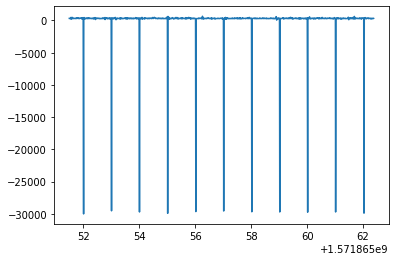

In [137]:
plt.plot(traj[55000:56000 - 1, 0], np.diff(traj[55000:56000, 7]))

In [134]:
traj[-1][0] - traj[0][0], len(traj)

(648.7159998416901, 59810)

In [131]:
s1 = RatCAVESession(session)

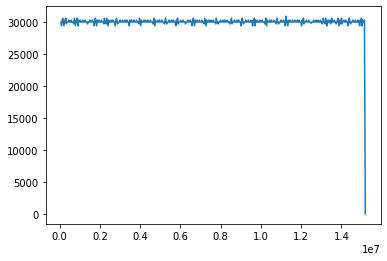

In [132]:
plt.plot(s1.events[:-1, 0], np.diff(s1.events[:, 0]))

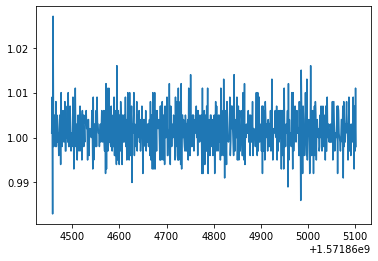

In [133]:
plt.plot(s1.events[:-1, 1], np.diff(s1.events[:, 1]))

In [74]:
len(np.where(np.diff(s1.events[:, 1]) > 50)[0])

1

In [70]:
s1.events[290:305][:, 0] #- s1.events[0][1]

array([8772600., 8802600., 8832600., 8862600., 8892900., 8922900.,
       8952900., 8982900., 9012600., 9012600., 9043200., 9072600.,
       9102900., 9132900., 9162900.])

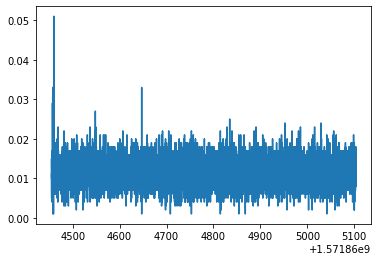

In [138]:
plt.plot(traj[:-1, 0], np.diff(traj[:, 0]))

In [79]:
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']

for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        filepath = os.path.join(source, animal, session, 'messages.events')
        fr, events = load_events(filepath)
        if len(np.where(np.diff(events[:, 1]) > 5)[0]) > 0:
            print(animal, session)

00908 2019-07-16_18-30-55
00910 2019-07-24_10-59-13
003908 2020-05-03_17-42-23


In [83]:
def get_sessions_diff_in_samples(source_dat_A, source_event_A, source_event_B, channels=64, dt_size=2):
    # number of samples in the source_dat_A file
    samples_A = os.path.getsize(source_dat_A) / channels / dt_size

    with open(source_event_A) as f_A:
        lines_A = f_A.readlines()
        first_sample_A = int(lines_A[0].split(' ')[0])

    with open(source_event_B) as f_B:
        lines_B = f_B.readlines()
        first_sample_B = int(lines_B[0].split(' ')[0])

    return first_sample_B - (first_sample_A + samples_A)

session = '/home/andrey/storage2/andrey/data/processed/00908/2019-07-16_18-30-55'

source_dat_A = os.path.join(session, '2019-07-16_18-27-55', 'all.dat')
source_event_A = os.path.join(session, '2019-07-16_18-27-55', 'messages.events')
source_event_B = os.path.join(session, '2019-07-16_18-33-56', 'messages.events')

shift_in_samples = int(get_sessions_diff_in_samples(source_dat_A, source_event_A, source_event_B))

In [84]:
sampling_rate = 30000

In [88]:
def merge_event_files(source_event_A, source_event_B, destination_path, shift_in_samples, sampling_rate):
    processor_line = 0

    with open(source_event_B) as f_B:
        lines_B = f_B.readlines()

    with open(source_event_A) as f_A:
        lines_A = f_A.readlines()

    for i, line in enumerate(lines_B):
        if "Processor:" in line.split(' '):
            processor_line = i
            break
    else:
        raise ValueError("Processor specs (frequency etc.) not found")

    shift_in_time = shift_in_samples / sampling_rate

    with open(destination_path, 'w') as f:

        # first write entire A file to destination
        for line in lines_A:
            f.write(line)

        # then write only events from B file, shifted by sample_diff
        for line in lines_B[processor_line + 2:]:
            data = line.split(' ')
            d1 = int(data[0]) - int(shift_in_samples)
            d2 = float(data[2]) - shift_in_time
            data[0] = "%s" % d1  # shift by a diff number of samples
            data[2] = "%.6f" % d2  # shift by a time diff

            f.write(' '.join(data))
            
merge_event_files(source_event_A, source_event_B, os.path.join(session, 'messages.events'), shift_in_samples, sampling_rate)

### fix wrong events

In [139]:
session = '/home/andrey/storage2/andrey/data/processed/003282/2019-10-23_23-00-59'

source = open(os.path.join(session, 'messages.events'), 'r')
dest = open(os.path.join(session, 'messages.new.events'), 'w')

s_prev, t_prev = 0, 0
for i, line in enumerate(source.readlines()):
    items = line.split(' ')
    if i > 10:
        if int(items[0]) >= 98829764:
            t_diff = float(items[2]) - t_prev
            items[0] = str(int(round(s_prev + t_diff * 30000)))

        s_prev = int(items[0])
        t_prev = float(items[2])
        
    dest.write(' '.join(items))

source.close()
dest.close()